In [4]:
# ============ IMPORTS ============
import os, json, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             precision_score, recall_score, f1_score, accuracy_score,
                             matthews_corrcoef, make_scorer,
                             ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay,precision_recall_curve)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

import shap

In [5]:
# ============ CONFIG ============
SAVE_DIR = "./artifacts_3333"
os.makedirs(SAVE_DIR, exist_ok=True)
TARGET = "churn"
RANDOM_STATE = 42
N_JOBS = -1

In [6]:
# ============ LOAD DATA ============
df = pd.read_csv("Churn-in-Telecom Dataset (3333).csv")
df = df.rename(columns=lambda c: c.strip())

print(df.info())
print(df.head())
print(df[TARGET].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

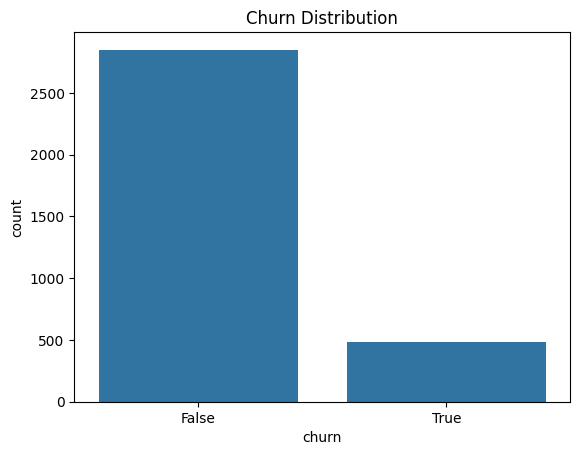

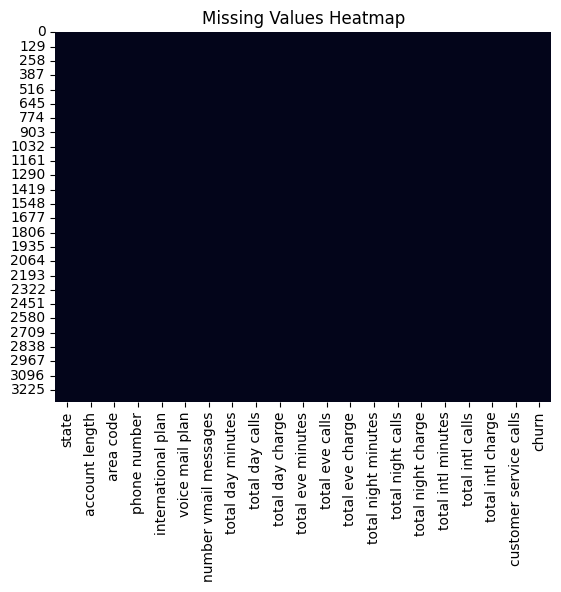

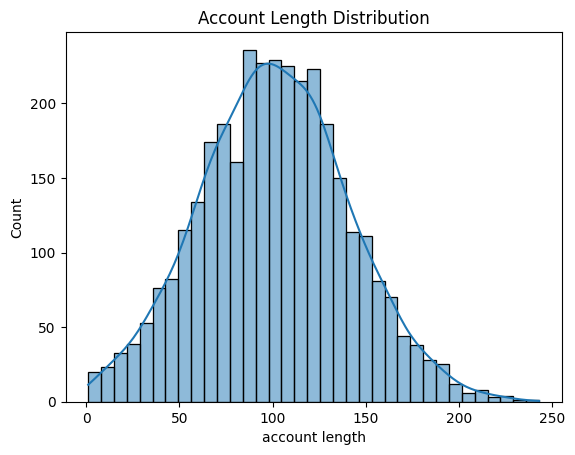

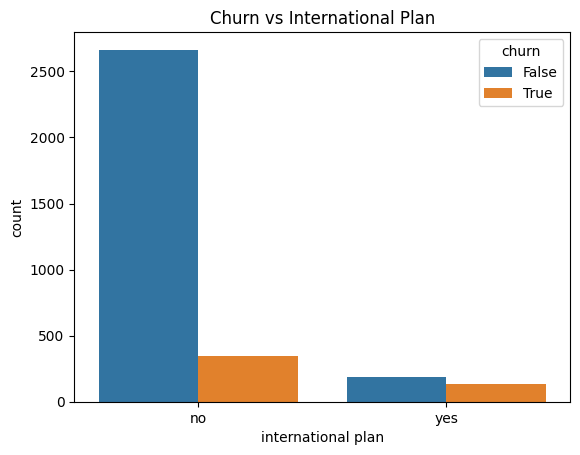

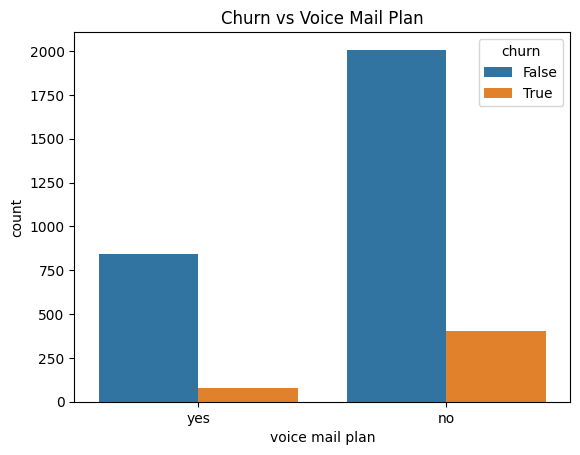

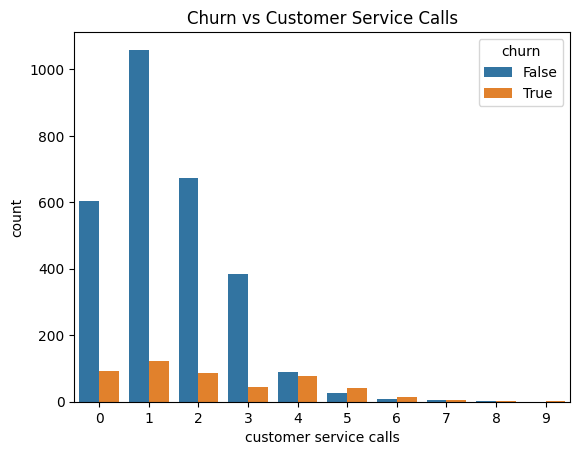

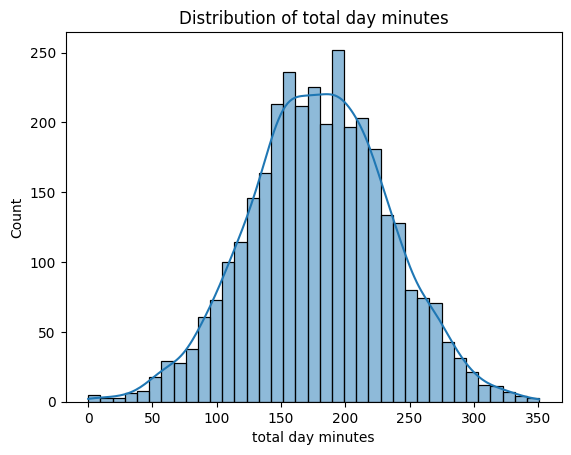

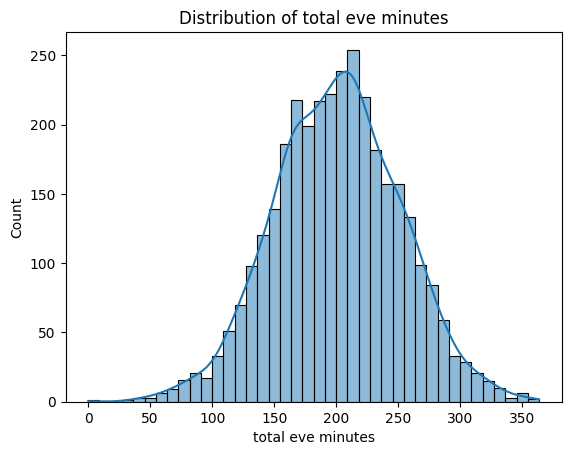

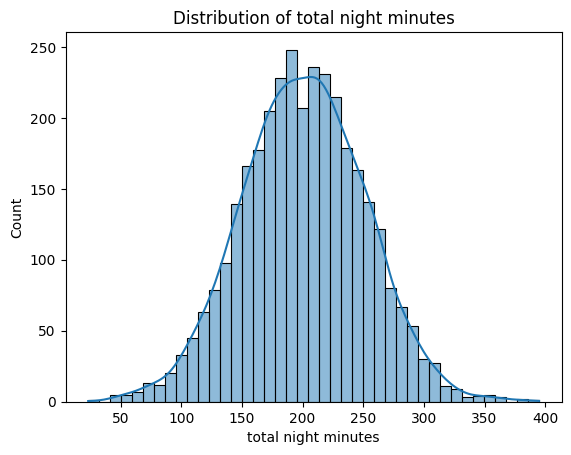

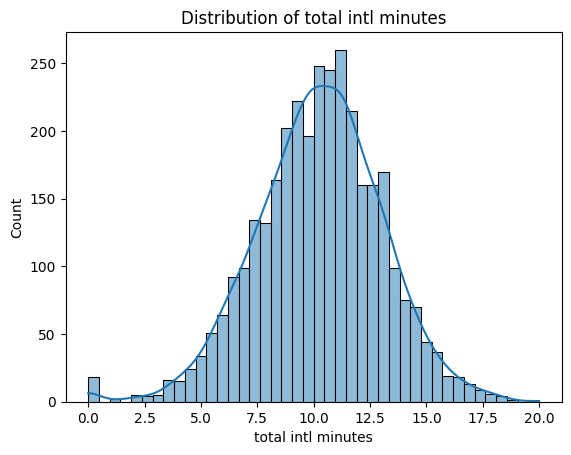

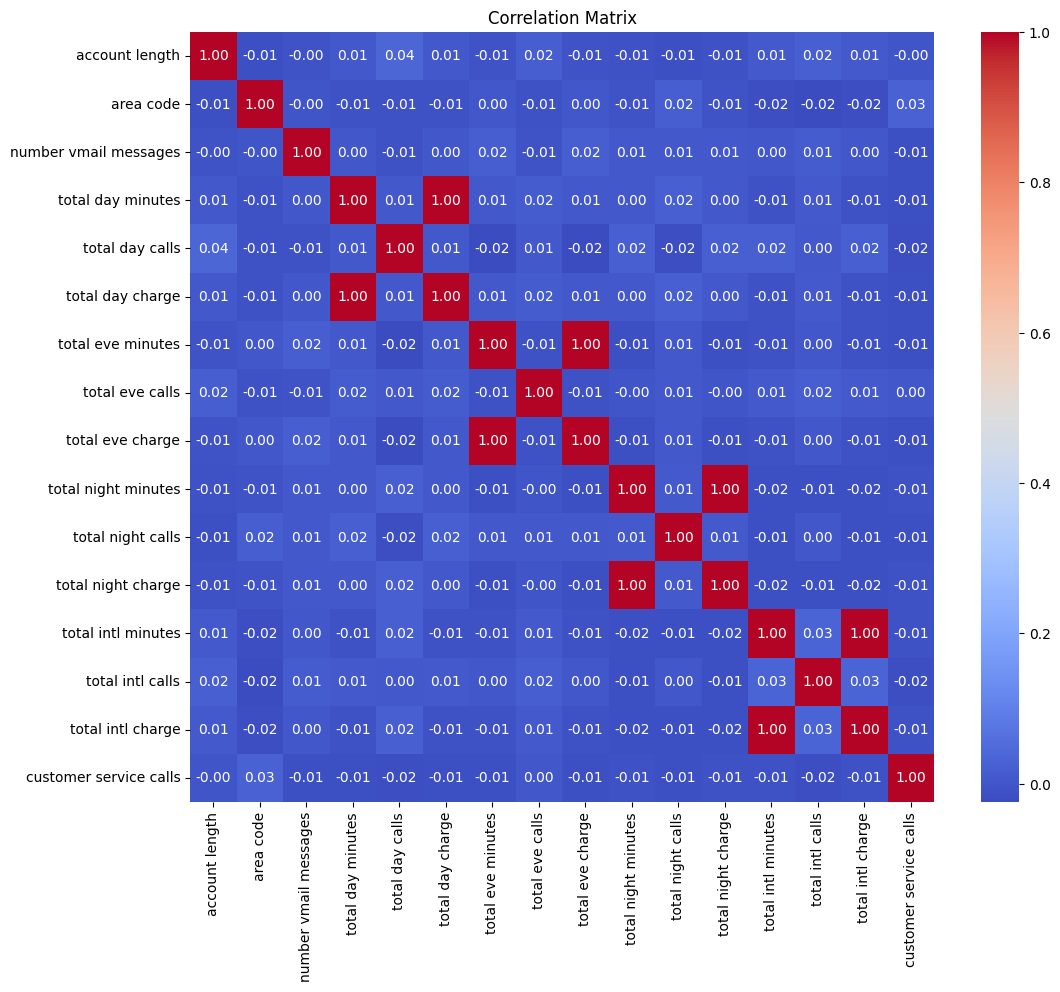

In [ ]:
#  Target balance
sns.countplot(x=TARGET, data=df)
plt.title("Churn Distribution")
plt.show()

# 2. Missing values
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

#  Account length distribution
if 'account length' in df.columns:
    sns.histplot(df['account length'], kde=True)
    plt.title("Account Length Distribution")
    plt.show()

#  Churn by International plan
if 'international plan' in df.columns:
    sns.countplot(x='international plan', hue=TARGET, data=df)
    plt.title("Churn vs International Plan")
    plt.show()

#  Churn by Voice mail plan
if 'voice mail plan' in df.columns:
    sns.countplot(x='voice mail plan', hue=TARGET, data=df)
    plt.title("Churn vs Voice Mail Plan")
    plt.show()

#  Churn by Customer service calls
if 'customer service calls' in df.columns:
    sns.countplot(x='customer service calls', hue=TARGET, data=df)
    plt.title("Churn vs Customer Service Calls")
    plt.show()

#  Distribution of total minutes/charges
for col in ['total day minutes','total eve minutes','total night minutes','total intl minutes']:
    if col in df.columns:
        sns.histplot(df[col], kde=True)
        plt.title(f"Distribution of {col}")
        plt.show()
# Correlation heatmap
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=np.number)
corr = numeric_df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [ ]:
# ============ FEATURE ENGINEERING ============
# Drop IDs
for idcol in ['phone number','phone_number','phone','state','State']:
    if idcol in df.columns:
        df.drop(columns=[idcol], inplace=True)

# Binary encoding
df[TARGET] = df[TARGET].map({'yes':1,'no':0,'Yes':1,'No':0, True:1, False:0}).astype(int)

# Derived features
def safe_sum(df, cols):
    return np.sum([df[c] for c in cols if c in df.columns], axis=0)

if any(c in df.columns for c in ['total day charge','total eve charge','total night charge','total intl charge']):
    df['total_charge'] = safe_sum(df, ['total day charge','total eve charge','total night charge','total intl charge'])
if any(c in df.columns for c in ['total day minutes','total eve minutes','total night minutes','total intl minutes']):
    df['total_minutes'] = safe_sum(df, ['total day minutes','total eve minutes','total night minutes','total intl minutes'])
if any(c in df.columns for c in ['total day calls','total eve calls','total night calls','total intl calls']):
    df['total_calls'] = safe_sum(df, ['total day calls','total eve calls','total night calls','total intl calls'])

for num, den, new in [
    ('total day minutes','total day calls','day_minutes_per_call'),
    ('total eve minutes','total eve calls','eve_minutes_per_call'),
    ('total night minutes','total night calls','night_minutes_per_call'),
]:
    if num in df.columns and den in df.columns:
        df[new] = df[num] / (df[den].replace(0, np.nan) + 1e-5)

if 'customer service calls' in df.columns and 'account length' in df.columns:
    df['service_call_frequency'] = df['customer service calls'] / (df['account length'] + 1)

if 'total_charge' in df.columns and 'total_minutes' in df.columns:
    df['charge_per_minute'] = df['total_charge'] / (df['total_minutes'] + 1e-5)

if 'international plan' in df.columns and 'customer service calls' in df.columns:
    df['intl_plan_service_calls'] = df['international plan'] * df['customer service calls']
if 'voice mail plan' in df.columns and 'customer service calls' in df.columns:
    df['vmail_plan_service_calls'] = df['voice mail plan'] * df['customer service calls']

num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols_all:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

# View newly engineered features
df.head()

,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,...,total_charge,total_minutes,total_calls,day_minutes_per_call,eve_minutes_per_call,night_minutes_per_call,service_call_frequency,charge_per_minute,intl_plan_service_calls,vmail_plan_service_calls
0,128,415,no,yes,25,265.1,110,45.07,197.4,99,...,75.56,717.2,303,2.410000,1.993939,2.689011,0.007752,0.105354,no,yes
1,107,415,no,yes,26,161.6,123,27.47,195.5,103,...,59.24,625.2,332,1.313821,1.898058,2.469903,0.009259,0.094754,no,yes
2,137,415,no,no,0,243.4,114,41.38,121.2,110,...,62.29,539.4,333,2.135088,1.101818,1.563461,0.000000,0.115480,,
3,84,408,yes,no,0,299.4,71,50.90,61.9,88,...,66.80,564.8,255,4.216901,0.703409,2.212359,0.023529,0.118272,yesyes,nono
4,75,415,yes,no,0,166.7,113,28.34,148.3,122,...,52.09,512.0,359,1.475221,1.215574,1.544628,0.039474,0.101738,yesyesyes,nonono


In [ ]:
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

In [ ]:
best_params = {
    "RF": {"n_estimators":300, "max_depth":12, "min_samples_leaf":3, "random_state":RANDOM_STATE},
    "GB": {"n_estimators":200, "learning_rate":0.1, "max_depth":3, "random_state":RANDOM_STATE},
    "LR": {"C":1, "penalty":"l2", "solver":"liblinear", "random_state":RANDOM_STATE}
}

models = {"RF": RandomForestClassifier, "GB": GradientBoostingClassifier, "LR": LogisticRegression}

samplers = {"SMOTE": SMOTE(random_state=RANDOM_STATE),
            "SMOTEENN": SMOTEENN(random_state=RANDOM_STATE),
            "SMOTETomek": SMOTETomek(random_state=RANDOM_STATE)}


In [ ]:
# ============ FUNCTION ============
def run_experiment(model_name, sampler_name, resampler):
    exp_name = f"{model_name}_{sampler_name}"
    model_path = os.path.join(SAVE_DIR, f"{exp_name}_pipeline.pkl")
    meta_path = os.path.join(SAVE_DIR, f"{exp_name}_meta.json")

    if os.path.exists(model_path) and os.path.exists(meta_path):
        print(f"🔄 Loading saved model: {exp_name}")
        best_pipe = joblib.load(model_path)
        with open(meta_path,"r") as f: meta = json.load(f)
    else:
        print(f"🚀 Training: {exp_name}")
        tuned_clf = models[model_name](**best_params[model_name])
        pipe = ImbPipeline([("preproc", preprocessor), ("resample", resampler), ("clf", tuned_clf)])
        pipe.fit(X_train, y_train)
        joblib.dump(pipe, model_path)

        y_train_prob = cross_val_predict(pipe, X_train, y_train, cv=3, method="predict_proba")[:,1]
        prec, rec, thresh = precision_recall_curve(y_train, y_train_prob)
        f1s = 2*prec*rec/(prec+rec+1e-12)
        best_idx = np.argmax(f1s)
        best_thresh = float(thresh[best_idx]) if best_idx < len(thresh) else 0.5

        meta = {
            "best_params": best_params[model_name],
            "best_threshold": best_thresh
        }
        with open(meta_path,"w") as f: json.dump(meta,f)
        best_pipe = pipe

    y_test_prob = best_pipe.predict_proba(X_test)[:,1]
    y_test_pred = (y_test_prob >= meta["best_threshold"]).astype(int)

    # 10-fold CV Accuracy
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    cv_acc = cross_val_score(best_pipe, X, y, cv=cv, scoring="accuracy", n_jobs=N_JOBS)
    cv_f1 = cross_val_score(best_pipe, X, y, cv=cv, scoring="f1", n_jobs=N_JOBS)

    res = {
        "model": model_name,
        "sampler": sampler_name,
        "roc_auc": roc_auc_score(y_test, y_test_prob),
        "f1": f1_score(y_test, y_test_pred),
        "precision": precision_score(y_test, y_test_pred),
        "recall": recall_score(y_test, y_test_pred),
        "accuracy": accuracy_score(y_test, y_test_pred),
        "cv_accuracy_mean": cv_acc.mean(),
        "cv_accuracy_std": cv_acc.std(),
        "cv_f1_mean": cv_f1.mean(),
        "cv_f1_std": cv_f1.std(),
        "mcc": matthews_corrcoef(y_test, y_test_pred),
        "confusion_matrix": confusion_matrix(y_test, y_test_pred),
        "probs": y_test_prob
    }
    return res

In [ ]:
all_results = []
for mname in models.keys():
    for sname,sampler in samplers.items():
        res = run_experiment(mname, sname, sampler)
        all_results.append(res)

summary_df = pd.DataFrame(all_results)
summary_df.to_csv(os.path.join(SAVE_DIR,"summary_results.csv"), index=False)
print(summary_df)



🚀 Training: RF_SMOTE
🚀 Training: RF_SMOTEENN
🚀 Training: RF_SMOTETomek
🚀 Training: GB_SMOTE
🚀 Training: GB_SMOTEENN
🚀 Training: GB_SMOTETomek
🚀 Training: LR_SMOTE
🚀 Training: LR_SMOTEENN
🚀 Training: LR_SMOTETomek
  model     sampler   roc_auc        f1  precision    recall  accuracy  \
0    RF       SMOTE  0.899367  0.826816   0.902439  0.762887  0.953523   
1    RF    SMOTEENN  0.893742  0.745946   0.784091  0.711340  0.929535   
2    RF  SMOTETomek  0.899367  0.826816   0.902439  0.762887  0.953523   
3    GB       SMOTE  0.902134  0.876404   0.962963  0.804124  0.967016   
4    GB    SMOTEENN  0.888443  0.819672   0.872093  0.773196  0.950525   
5    GB  SMOTETomek  0.902134  0.876404   0.962963  0.804124  0.967016   
6    LR       SMOTE  0.857189  0.607595   0.514286  0.742268  0.860570   
7    LR    SMOTEENN  0.853970  0.601695   0.510791  0.731959  0.859070   
8    LR  SMOTETomek  0.857189  0.607595   0.514286  0.742268  0.860570   

   cv_accuracy_mean  cv_accuracy_std  cv_f1_me

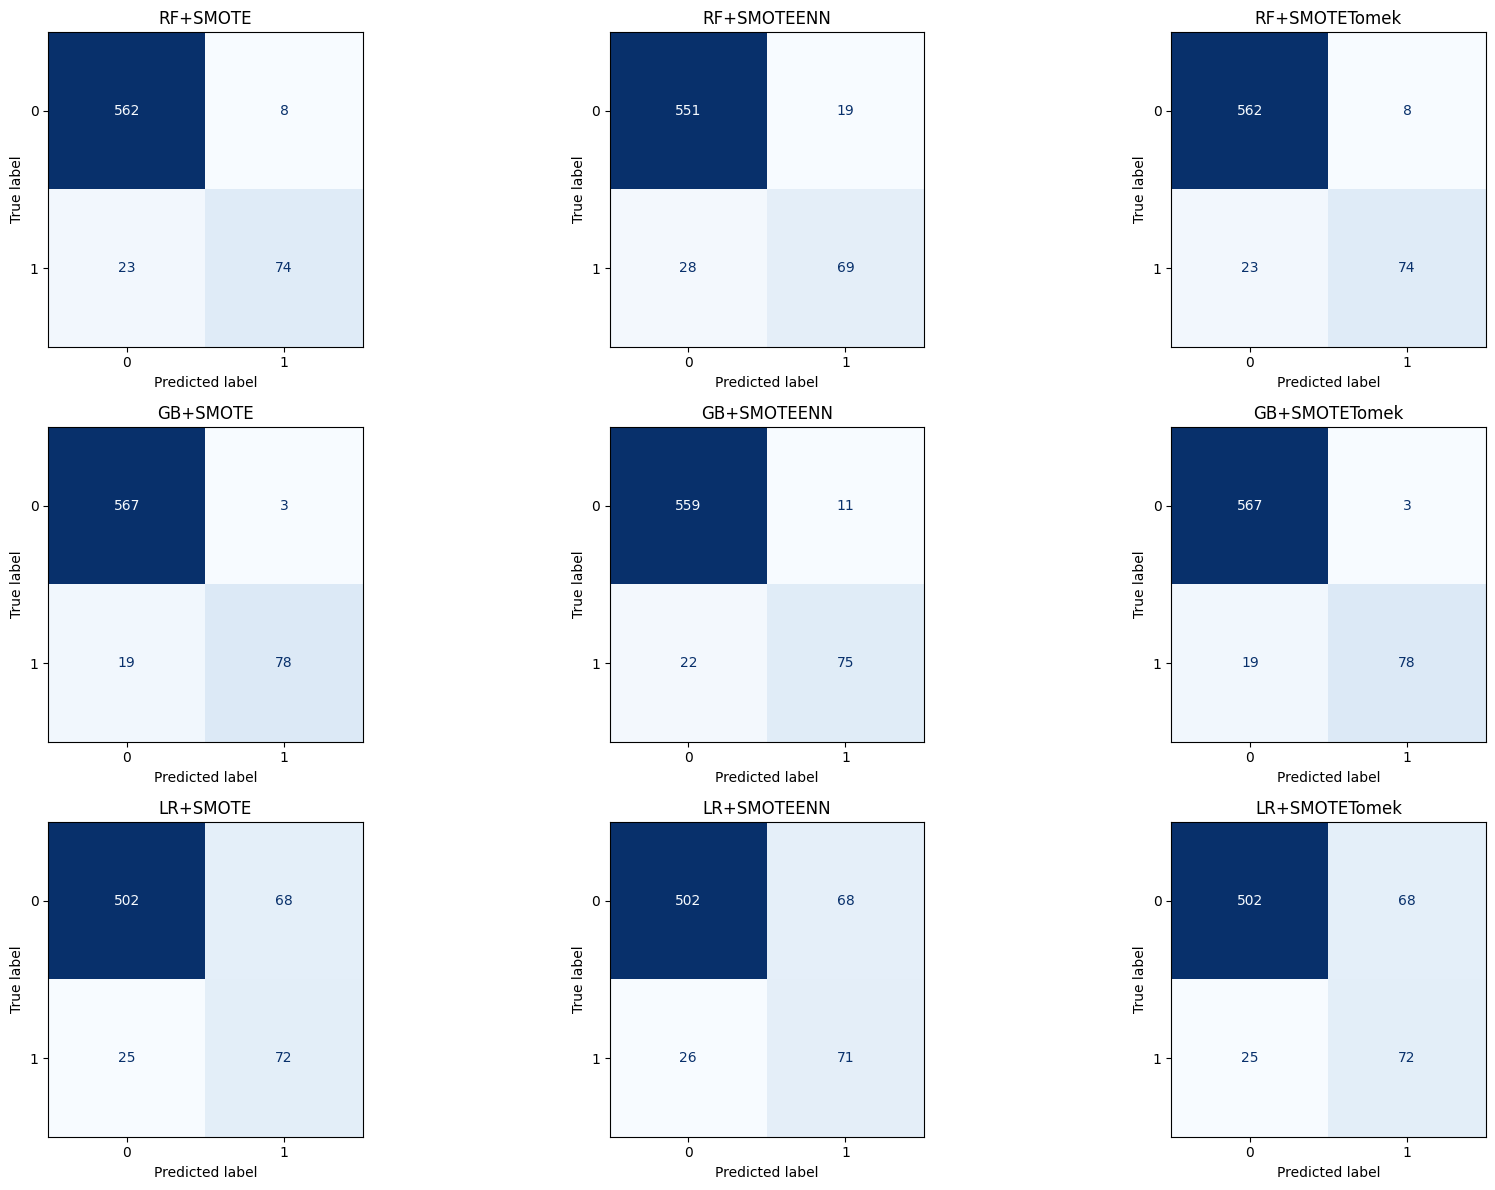

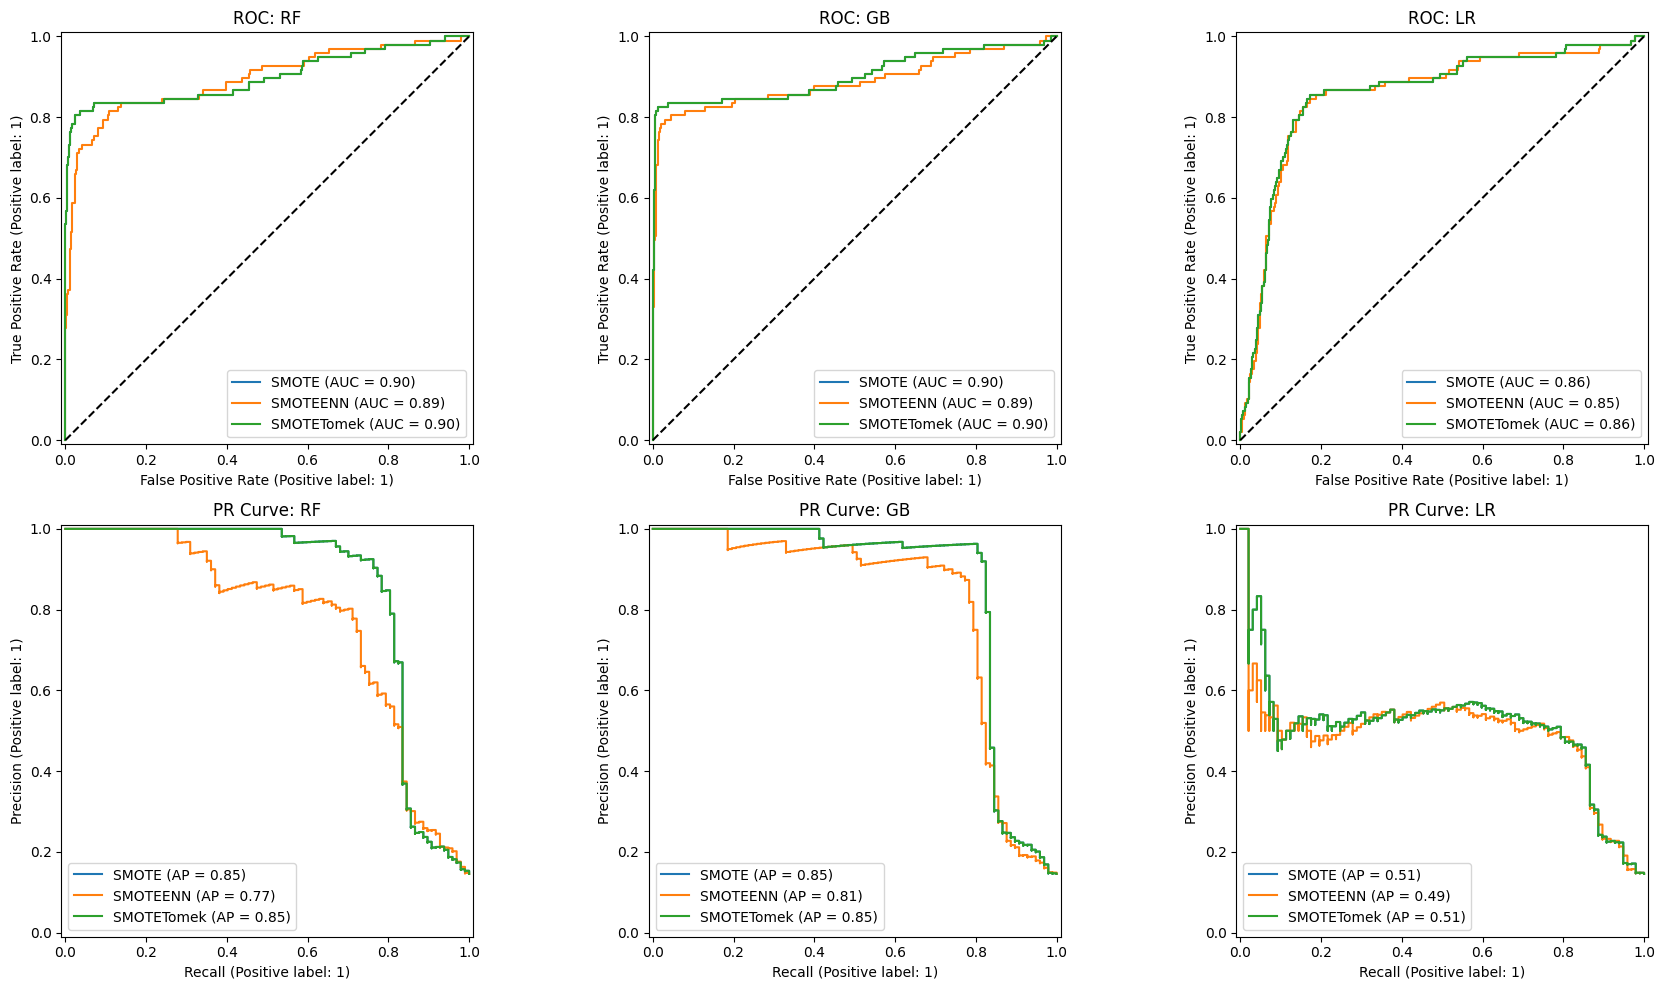

In [ ]:
# ============ PLOTS ============
# Confusion matrices
fig, axes = plt.subplots(len(models), len(samplers), figsize=(18,12))
for i,mname in enumerate(models.keys()):
    for j,sname in enumerate(samplers.keys()):
        ax = axes[i,j]
        r = next(r for r in all_results if r["model"]==mname and r["sampler"]==sname)
        ConfusionMatrixDisplay(r["confusion_matrix"]).plot(ax=ax, cmap="Blues", colorbar=False)
        ax.set_title(f"{mname}+{sname}")
plt.tight_layout()
plt.show()

# ROC and PR curves in subplots
fig, axes = plt.subplots(2,len(models), figsize=(18,10))

for i,mname in enumerate(models.keys()):
    # ROC
    ax = axes[0,i]
    for sname in samplers.keys():
        r = next(r for r in all_results if r["model"]==mname and r["sampler"]==sname)
        RocCurveDisplay.from_predictions(y_test, r["probs"], name=sname, ax=ax)
    ax.plot([0,1],[0,1],"k--")
    ax.set_title(f"ROC: {mname}")

    # Precision-Recall
    ax = axes[1,i]
    for sname in samplers.keys():
        r = next(r for r in all_results if r["model"]==mname and r["sampler"]==sname)
        PrecisionRecallDisplay.from_predictions(y_test, r["probs"], name=sname, ax=ax)
    ax.set_title(f"PR Curve: {mname}")

plt.tight_layout()
plt.show()


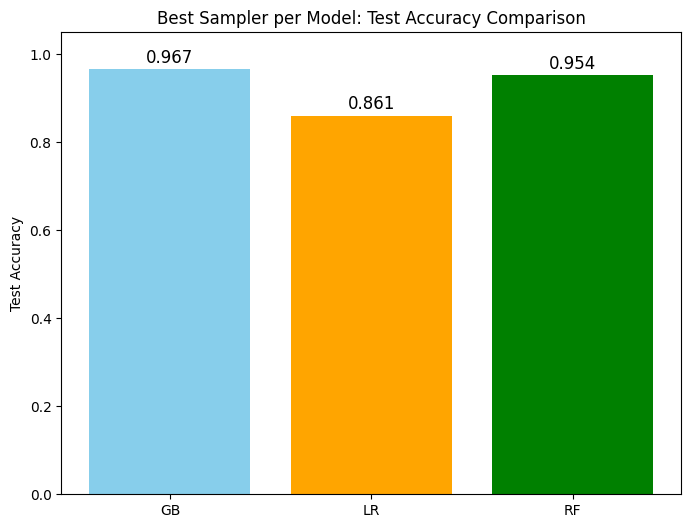

  model sampler  accuracy  cv_accuracy_mean  cv_accuracy_std
3    GB   SMOTE  0.967016          0.977798         0.006997
6    LR   SMOTE  0.860570          0.849684         0.020183
0    RF   SMOTE  0.953523          0.967292         0.006924


In [ ]:
best_results = summary_df.loc[summary_df.groupby('model')['accuracy'].idxmax()]
plt.figure(figsize=(8,6))
plt.bar(best_results['model'], best_results['accuracy'], color=['skyblue','orange','green'])
for i, acc in enumerate(best_results['accuracy']):
    plt.text(i, acc+0.005, f"{acc:.3f}", ha='center', va='bottom', fontsize=12)
plt.ylim(0, 1.05)
plt.ylabel("Test Accuracy")
plt.title("Best Sampler per Model: Test Accuracy Comparison")
plt.show()

print(best_results[['model','sampler','accuracy','cv_accuracy_mean','cv_accuracy_std']])



===== Best sampler for RF =====
Sampler: SMOTE
Classification Report:


array([[562,   8],
       [ 23,  74]])


===== Best sampler for GB =====
Sampler: SMOTE
Classification Report:


array([[567,   3],
       [ 19,  78]])


===== Best sampler for LR =====
Sampler: SMOTE
Classification Report:


array([[502,  68],
       [ 25,  72]])

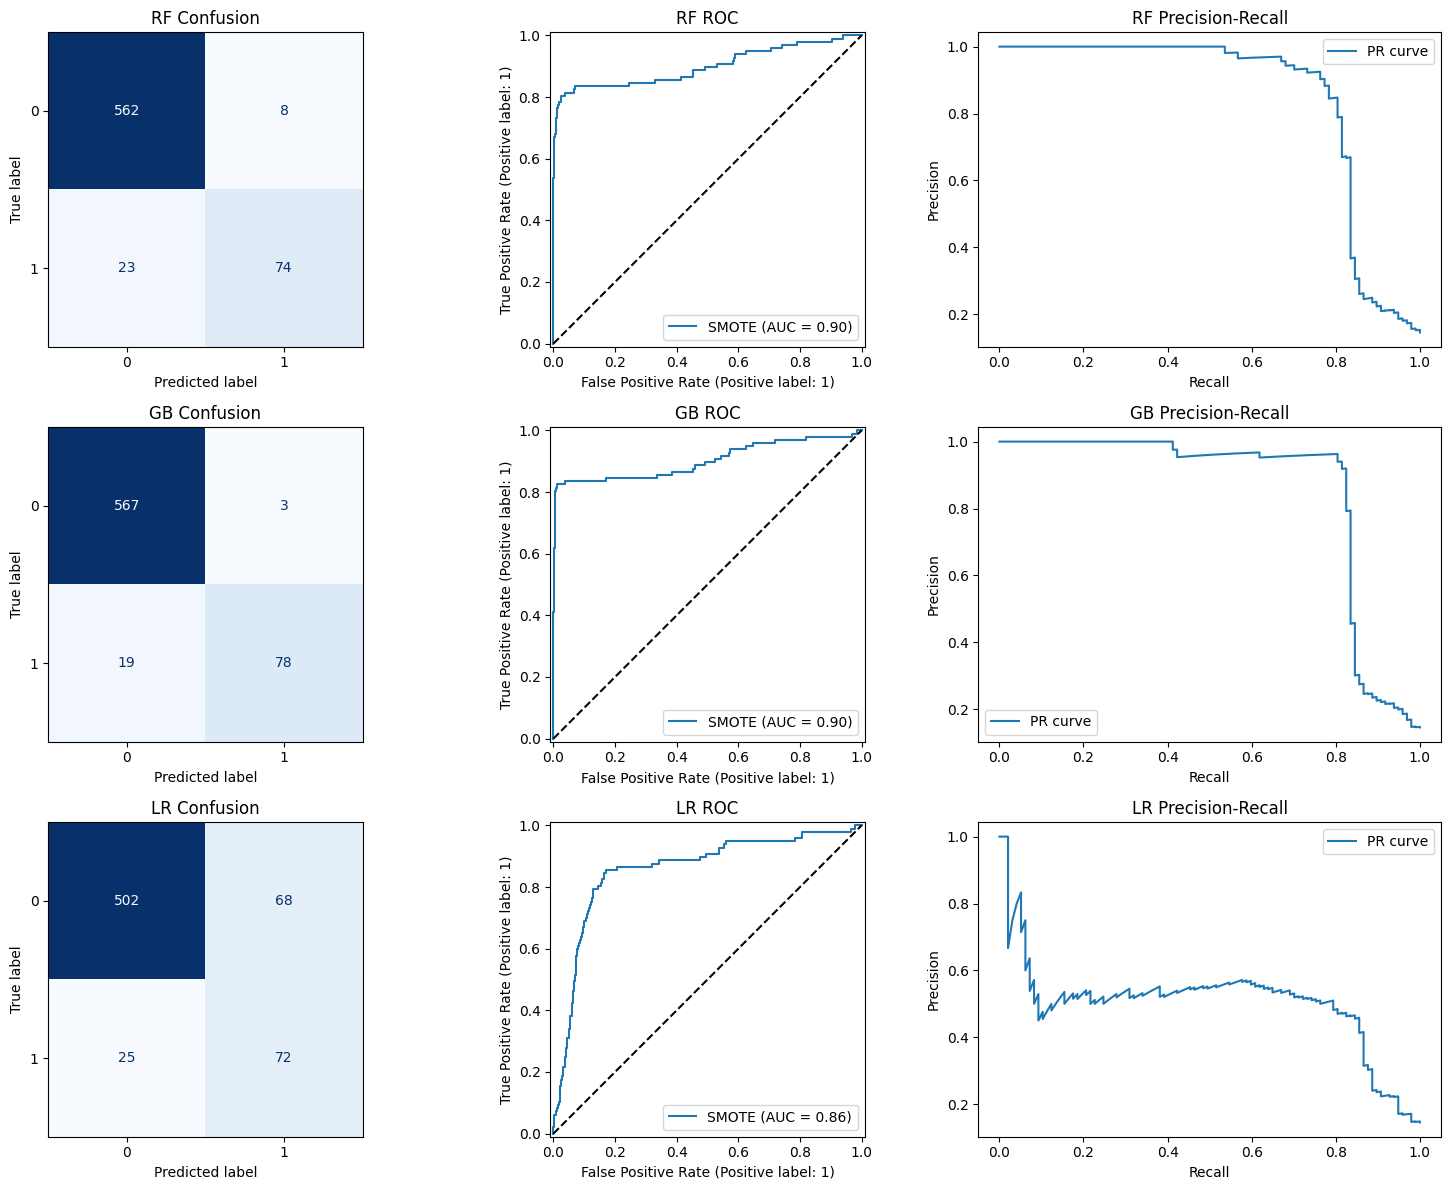

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_curve

best_results = {}
for model_name in ["RF", "GB", "LR"]:
    # Select row with highest F1
    subset = summary_df[summary_df["model"]==model_name]
    best_row = subset.loc[subset["f1"].idxmax()]
    best_results[model_name] = best_row

    # Print classification report
    print(f"\n===== Best sampler for {model_name} =====")
    print("Sampler:", best_row["sampler"])
    print("Classification Report:")
    display(best_row["confusion_matrix"])
    y_test_pred = best_row["confusion_matrix"]

# ============ Plot Confusion Matrix, ROC, PR ============

fig, axes = plt.subplots(3,3, figsize=(15,12))

for i, model_name in enumerate(["RF","GB","LR"]):
    best_row = best_results[model_name]
    sampler_name = best_row["sampler"]

    # Load pipeline
    pipeline_path = f"{SAVE_DIR}/{model_name}_{sampler_name}_pipeline.pkl"
    pipe = joblib.load(pipeline_path)

    # Threshold tuning
    y_test_prob = pipe.predict_proba(X_test)[:,1]
    meta_path = f"{SAVE_DIR}/{model_name}_{sampler_name}_meta.json"
    with open(meta_path,"r") as f:
        meta = json.load(f)
    best_threshold = meta.get("best_threshold",0.5)
    y_test_pred = (y_test_prob >= best_threshold).astype(int)

    # Confusion matrix
    ax = axes[i,0]
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred)).plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(f"{model_name} Confusion")

    # ROC
    ax = axes[i,1]
    RocCurveDisplay.from_predictions(y_test, y_test_prob, name=sampler_name, ax=ax)
    ax.plot([0,1],[0,1],"k--")
    ax.set_title(f"{model_name} ROC")

    # Precision-Recall
    ax = axes[i,2]
    precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
    ax.plot(recall, precision, label="PR curve")
    ax.set_title(f"{model_name} Precision-Recall")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.legend()

plt.tight_layout()
plt.show()

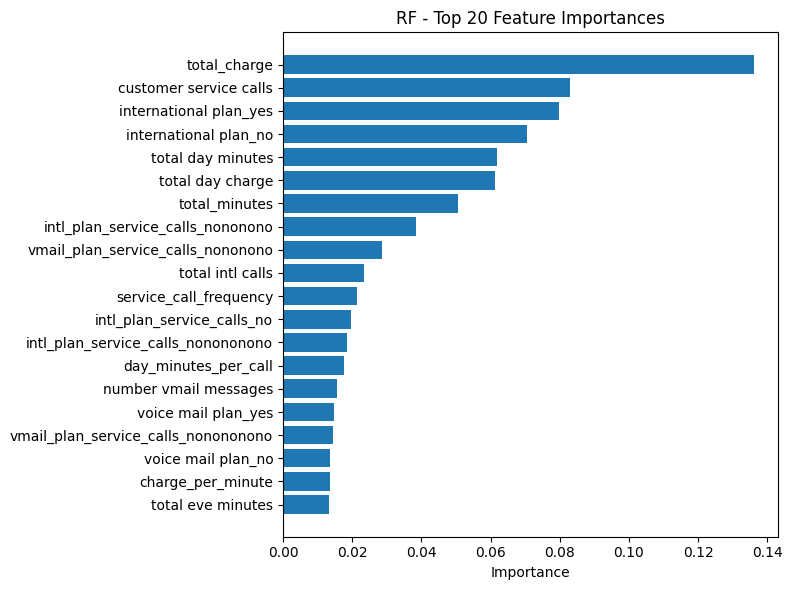

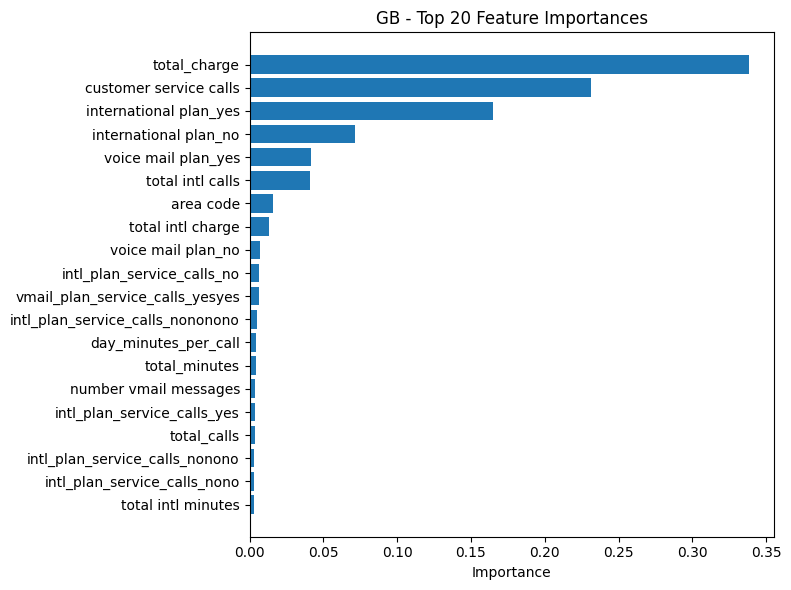

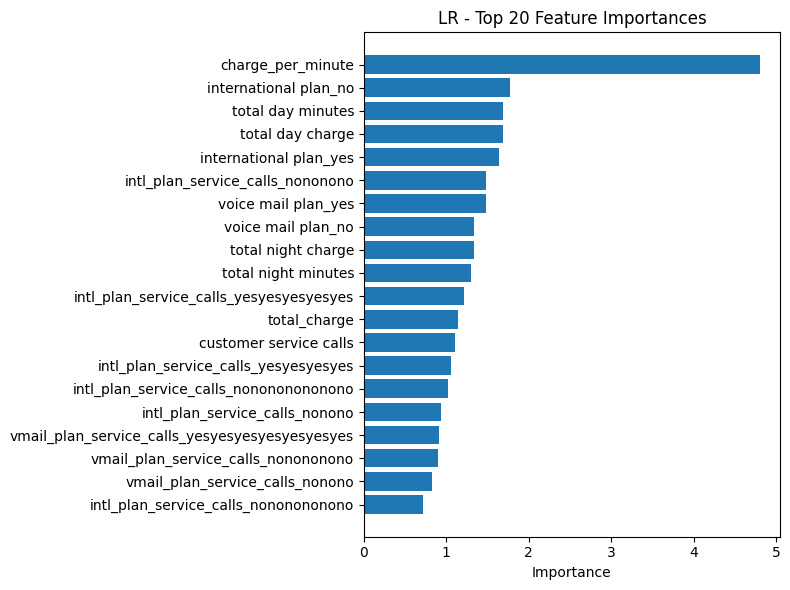

In [ ]:
# Helper to extract feature names after preprocessing
def get_feature_names(preprocessor, input_features):
    feature_names = []
    for name, trans, cols in preprocessor.transformers_:
        if name == 'remainder':
            continue
        if hasattr(trans, 'get_feature_names_out'):
            names = trans.get_feature_names_out(cols)
        else:
            names = cols
        feature_names.extend(names)
    return feature_names

for model_name in ["RF", "GB", "LR"]:
    best_row = best_results[model_name]
    sampler_name = best_row["sampler"]
    pipe = joblib.load(f"{SAVE_DIR}/{model_name}_{sampler_name}_pipeline.pkl")

    # Get full feature names after preprocessing
    feature_names = get_feature_names(pipe.named_steps['preproc'], X.columns)

    # Get importances or coefficients
    if model_name == "LR":
        importances = np.abs(pipe.named_steps['clf'].coef_[0])
    else:
        importances = pipe.named_steps['clf'].feature_importances_

    # Top 20 indices
    indices = np.argsort(importances)[-20:]

    # Plot
    plt.figure(figsize=(8,6))
    plt.barh(np.array(feature_names)[indices], importances[indices])
    plt.title(f"{model_name} - Top 20 Feature Importances")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
import os, joblib, json
from sklearn.model_selection import train_test_split

DATA_PATH = "/content/Churn-in-Telecom Dataset (3333).csv"
TARGET = "churn"
df = pd.read_csv(DATA_PATH)
df = df.rename(columns=lambda c: c.strip())

# Drop ID / non-informative columns safely
for col in ['state','phone_number','phone','id']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# Drop IDs
for idcol in ['phone number','phone_number','phone','state','State']:
    if idcol in df.columns:
        df.drop(columns=[idcol], inplace=True)

# Binary encoding
df[TARGET] = df[TARGET].map({'yes':1,'no':0,'Yes':1,'No':0, True:1, False:0}).astype(int)

# Derived features
def safe_sum(df, cols):
    return np.sum([df[c] for c in cols if c in df.columns], axis=0)

if any(c in df.columns for c in ['total day charge','total eve charge','total night charge','total intl charge']):
    df['total_charge'] = safe_sum(df, ['total day charge','total eve charge','total night charge','total intl charge'])
if any(c in df.columns for c in ['total day minutes','total eve minutes','total night minutes','total intl minutes']):
    df['total_minutes'] = safe_sum(df, ['total day minutes','total eve minutes','total night minutes','total intl minutes'])
if any(c in df.columns for c in ['total day calls','total eve calls','total night calls','total intl calls']):
    df['total_calls'] = safe_sum(df, ['total day calls','total eve calls','total night calls','total intl calls'])

for num, den, new in [
    ('total day minutes','total day calls','day_minutes_per_call'),
    ('total eve minutes','total eve calls','eve_minutes_per_call'),
    ('total night minutes','total night calls','night_minutes_per_call'),
]:
    if num in df.columns and den in df.columns:
        df[new] = df[num] / (df[den].replace(0, np.nan) + 1e-5)

if 'customer service calls' in df.columns and 'account length' in df.columns:
    df['service_call_frequency'] = df['customer service calls'] / (df['account length'] + 1)

if 'total_charge' in df.columns and 'total_minutes' in df.columns:
    df['charge_per_minute'] = df['total_charge'] / (df['total_minutes'] + 1e-5)

if 'international plan' in df.columns and 'customer service calls' in df.columns:
    df['intl_plan_service_calls'] = df['international plan'] * df['customer service calls']
if 'voice mail plan' in df.columns and 'customer service calls' in df.columns:
    df['vmail_plan_service_calls'] = df['voice mail plan'] * df['customer service calls']

# Fill missing numeric values
for c in df.select_dtypes(include=[np.number]).columns:
    df[c] = df[c].fillna(df[c].median())

X = df.drop(columns=[TARGET])
y = df[TARGET]

# Train-test split
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)

print("✅ Data loaded and feature-engineered.")

SAVE_DIR = "./artifacts_3333"
models = ["RF","GB","LR"]
pipelines, metas = {}, {}

for m in models:
    # Pick default sampler; assume best sampler stored in meta
    pipeline_path = os.path.join(SAVE_DIR, f"{m}_SMOTE_pipeline.pkl")
    meta_path = os.path.join(SAVE_DIR, f"{m}_SMOTE_meta.json")

    pipelines[m] = joblib.load(pipeline_path)
    with open(meta_path,"r") as f:
        metas[m] = json.load(f)
    print(f"✅ Loaded {m}_SMOTE pipeline with threshold {metas[m].get('best_threshold',0.5)}")

✅ Data loaded and feature-engineered.
✅ Loaded RF_SMOTE pipeline with threshold 0.5396267322277039
✅ Loaded GB_SMOTE pipeline with threshold 0.6663845034522613
✅ Loaded LR_SMOTE pipeline with threshold 0.612953220639164


,Model,Threshold,Targeted,Retained,Missed,Benefit($),Cost($),Net Profit($),ROI(%),Profit per Customer($)
1,GB,0.666385,422,419,64,41900,4220,37680,892.890995,11.305131
0,RF,0.539627,423,415,68,41500,4230,37270,881.087470,11.182118
2,LR,0.612953,667,366,117,36600,6670,29930,448.725637,8.979898


<Figure size 1200x600 with 0 Axes>

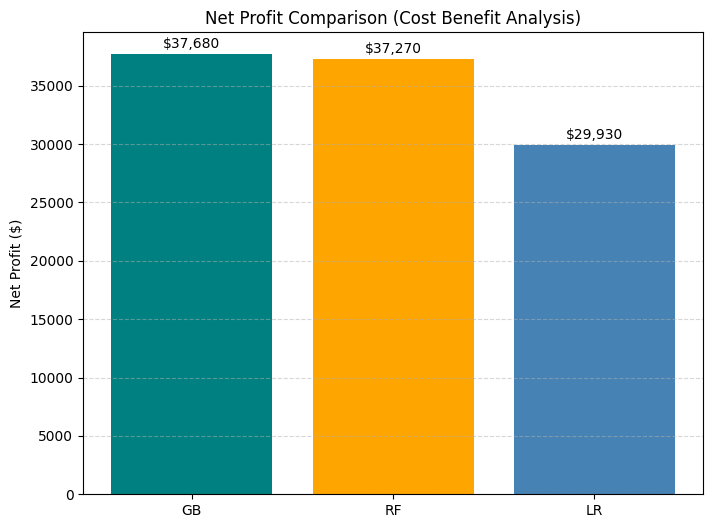

🏆 Best Model for Business: GB


In [ ]:
# ============ BUSINESS-FRIENDLY COST BENEFIT ANALYSIS + SUMMARY ============
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

profit_per_retained = 100
cost_per_contact = 10

cba_records = []

for m in models:
    pipe = pipelines[m]
    meta = metas[m]
    threshold = meta.get("best_threshold",0.5)

    y_prob = pipe.predict_proba(X)[:,1]
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

    targeted = tp + fp
    retained = tp
    missed = fn
    benefit = retained*profit_per_retained
    cost = targeted*cost_per_contact
    net_profit = benefit - cost
    roi = (net_profit / cost)*100 if cost>0 else 0
    profit_per_customer = net_profit / len(y)

    cba_records.append({
        "Model": m,
        "Threshold": threshold,
        "Targeted": targeted,
        "Retained": retained,
        "Missed": missed,
        "Benefit($)": benefit,
        "Cost($)": cost,
        "Net Profit($)": net_profit,
        "ROI(%)": roi,
        "Profit per Customer($)": profit_per_customer
    })

cba_df = pd.DataFrame(cba_records)
cba_df = cba_df.sort_values("Net Profit($)", ascending=False)
display(cba_df)

# Plot Net Profit
plt.figure(figsize=(8,6))
bars = plt.bar(cba_df["Model"], cba_df["Net Profit($)"], color=["teal","orange","steelblue"])
plt.title("Net Profit Comparison (Cost Benefit Analysis)")
plt.ylabel("Net Profit ($)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
for bar,val in zip(bars,cba_df["Net Profit($)"]):
    plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+500,f"${val:,.0f}",ha='center')
plt.show()

print(f"🏆 Best Model for Business: {cba_df.iloc[0]['Model']}")


In [ ]:
# =========================
# 💼 Business-Friendly Churn Prediction Project
# =========================

PROFIT_PER_RETAINED = 100   # Benefit per retained churner ($)
COST_PER_CONTACT = 10       # Cost per retention action ($)
BEST_MODEL = "GB"
BEST_SAMPLER = "SMOTE"
BEST_THRESHOLD = 0.666      # From previous analysis

RANDOM_STATE = 42

# -------------------------
# Load trained pipeline
# -------------------------
pipeline_path = os.path.join(SAVE_DIR, f"{BEST_MODEL}_{BEST_SAMPLER}_pipeline.pkl")
meta_path = os.path.join(SAVE_DIR, f"{BEST_MODEL}_{BEST_SAMPLER}_meta.json")

pipe = joblib.load(pipeline_path)
with open(meta_path, "r") as f:
    meta = json.load(f)
best_threshold = meta.get("best_threshold", BEST_THRESHOLD)

print(f"✅ Loaded pipeline: {BEST_MODEL} + {BEST_SAMPLER} | Threshold={best_threshold}")

# -------------------------
# Bulk Test Set Predictions + CBA
# -------------------------
y_prob = pipe.predict_proba(X)[:,1]
y_pred = (y_prob >= best_threshold).astype(int)

tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
targeted = tp + fp
retained = tp
missed = fn
benefit = retained * PROFIT_PER_RETAINED
cost = targeted * COST_PER_CONTACT
net_profit = benefit - cost
roi = (net_profit / cost) * 100 if cost>0 else 0
profit_per_customer = net_profit / len(y)

print("\n===== 💰 COST-BENEFIT SUMMARY =====")
print(f"Targeted Customers: {targeted}")
print(f"Retained Churners: {retained}")
print(f"Missed Churners: {missed}")
print(f"Benefit: ${benefit:,}")
print(f"Cost: ${cost:,}")
print(f"Net Profit: ${net_profit:,}")
print(f"ROI: {roi:.1f}%")
print(f"Profit per Customer: ${profit_per_customer:.2f}")

# High-risk customers
high_risk_customers = pd.DataFrame(X)
high_risk_customers["churn_prob"] = y_prob
high_risk_customers["action_needed"] = y_pred
high_risk_customers = high_risk_customers.sort_values(by="churn_prob", ascending=False)
print("\n📌 Top 10 High-Risk Customers:")
display(high_risk_customers.head(10))


✅ Loaded pipeline: GB + SMOTE | Threshold=0.6663845034522613

===== 💰 COST-BENEFIT SUMMARY =====
Targeted Customers: 422
Retained Churners: 419
Missed Churners: 64
Benefit: $41,900
Cost: $4,220
Net Profit: $37,680
ROI: 892.9%
Profit per Customer: $11.31

📌 Top 10 High-Risk Customers:


,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,...,total_calls,day_minutes_per_call,eve_minutes_per_call,night_minutes_per_call,service_call_frequency,charge_per_minute,intl_plan_service_calls,vmail_plan_service_calls,churn_prob,action_needed
2732,130,408,yes,no,0,216.2,106,36.75,363.7,86,...,317,2.039622,4.229069,1.030081,0.038168,0.107699,yesyesyesyesyes,nonononono,0.999686,1
985,64,415,yes,no,0,346.8,55,58.96,249.5,79,...,245,6.305453,3.158227,2.700000,0.015385,0.108644,yes,no,0.999449,1
2401,126,415,yes,no,0,239.7,87,40.75,281.7,92,...,293,2.755172,3.061956,1.623894,0.007874,0.106143,yes,no,0.999395,1
1192,88,415,yes,no,0,235.1,98,39.97,251.8,79,...,255,2.398979,3.187341,3.761842,0.044944,0.097667,yesyesyesyes,nononono,0.999342,1
1691,95,415,no,no,0,269.0,120,45.73,233.7,120,...,305,2.241666,1.947500,2.939344,0.020833,0.109720,nono,nono,0.999285,1
230,93,408,yes,no,0,312.0,109,53.04,129.4,100,...,285,2.862385,1.294000,2.940540,0.000000,0.114518,,,0.999163,1
1533,127,510,yes,no,0,242.2,102,41.17,226.1,80,...,283,2.374510,2.826250,2.625000,0.015625,0.102806,yesyes,nono,0.998948,1
1339,90,415,yes,no,0,148.2,96,25.19,220.4,111,...,305,1.543750,1.985585,1.383505,0.043956,0.102422,yesyesyesyes,nononono,0.998901,1
1662,197,415,yes,no,0,127.3,80,21.64,222.3,115,...,295,1.591250,1.933043,1.830526,0.025253,0.096929,yesyesyesyesyes,nonononono,0.998649,1
715,115,510,yes,no,0,249.9,95,42.48,242.5,104,...,326,2.630526,2.331731,1.253719,0.008621,0.112299,yes,no,0.998517,1


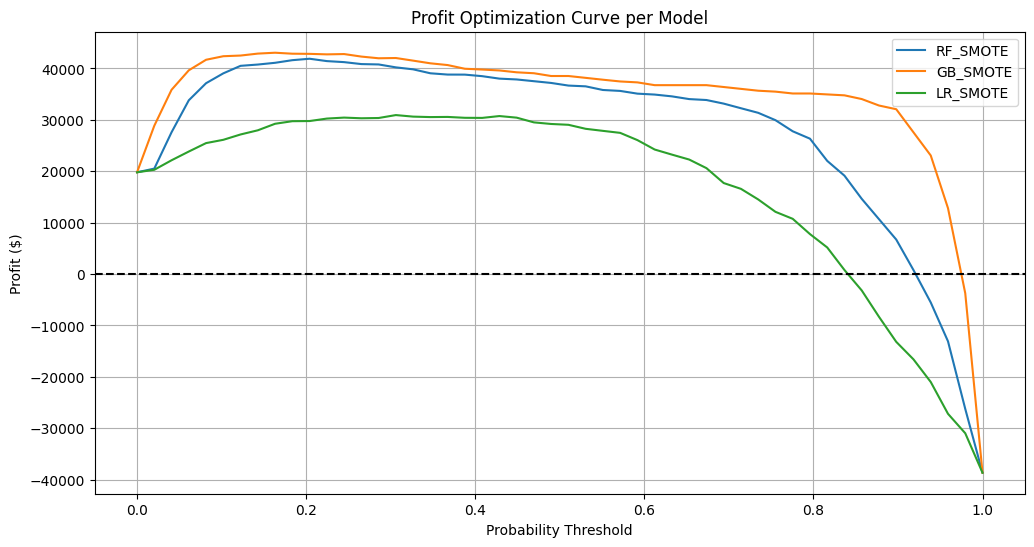

📊 Profit Optimization Summary:


,Model,Sampler,Meta_Threshold,Profit_Optimal_Threshold,Max_Profit
1,GB,SMOTE,0.666385,0.163,43060
0,RF,SMOTE,0.539627,0.204,41890
2,LR,SMOTE,0.612953,0.306,30930



🏆 Best Model for Profit: GB + SMOTE
💰 Max Profit: $43,060 at Threshold=0.163
📌 Meta Threshold used in pipeline: 0.6663845034522613


In [ ]:
# ==============================
# 💹 Profit Optimization Curve
# ==============================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import joblib

# Business assumptions
profit_per_retained = 100   # $ per correctly retained churner (TP)
cost_per_contact = 10       # $ per contacted customer (TP + FP)
loss_per_missed = 80        # $ per missed churner (FN) # Added loss_per_missed

# Thresholds to evaluate
thresholds = np.linspace(0, 1, 50)

profit_summary = []

plt.figure(figsize=(12,6))

for model_name in ["RF","GB","LR"]:
    sampler_name = "SMOTE" # Fixed to use the sampler name directly as used elsewhere

    # Load pipeline and meta
    pipe = joblib.load(f"./artifacts_3333/{model_name}_{sampler_name}_pipeline.pkl")
    meta = metas[model_name] # Corrected access to meta

    # Predicted probabilities
    y_prob = pipe.predict_proba(X)[:,1]

    # Compute profits for all thresholds
    profits = []
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
        # profit = tp*profit_per_retained - (tp+fp)*cost_per_contact # Original calculation
        profit = tp*profit_per_retained - fp*cost_per_contact - fn*loss_per_missed # Aligned with compute_profit function
        profits.append(profit)

    profits = np.array(profits)
    plt.plot(thresholds, profits, label=f"{model_name}_{sampler_name}")

    # Best threshold and max profit
    best_idx = np.argmax(profits)
    best_t = thresholds[best_idx]
    max_profit = profits[best_idx]

    profit_summary.append({
        "Model": model_name,
        "Sampler": sampler_name,
        "Meta_Threshold": meta.get("best_threshold",0.5),
        "Profit_Optimal_Threshold": round(best_t,3),
        "Max_Profit": round(max_profit,2)
    })

# Plot formatting
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Probability Threshold")
plt.ylabel("Profit ($)")
plt.title("Profit Optimization Curve per Model")
plt.grid(True)
plt.legend()
plt.show()

# Profit optimization summary table
profit_summary_df = pd.DataFrame(profit_summary).sort_values("Max_Profit", ascending=False)
print("📊 Profit Optimization Summary:")
display(profit_summary_df)

# Identify the best model by max profit
best_model = profit_summary_df.iloc[0]
print(f"\n🏆 Best Model for Profit: {best_model['Model']} + {best_model['Sampler']}")
print(f"💰 Max Profit: ${best_model['Max_Profit']:,} at Threshold={best_model['Profit_Optimal_Threshold']}")
print(f"📌 Meta Threshold used in pipeline: {best_model['Meta_Threshold']}")


===== SHAP Explanation for RF_SMOTE =====
Global SHAP - Beeswarm & Bar Plots


<Figure size 600x600 with 0 Axes>

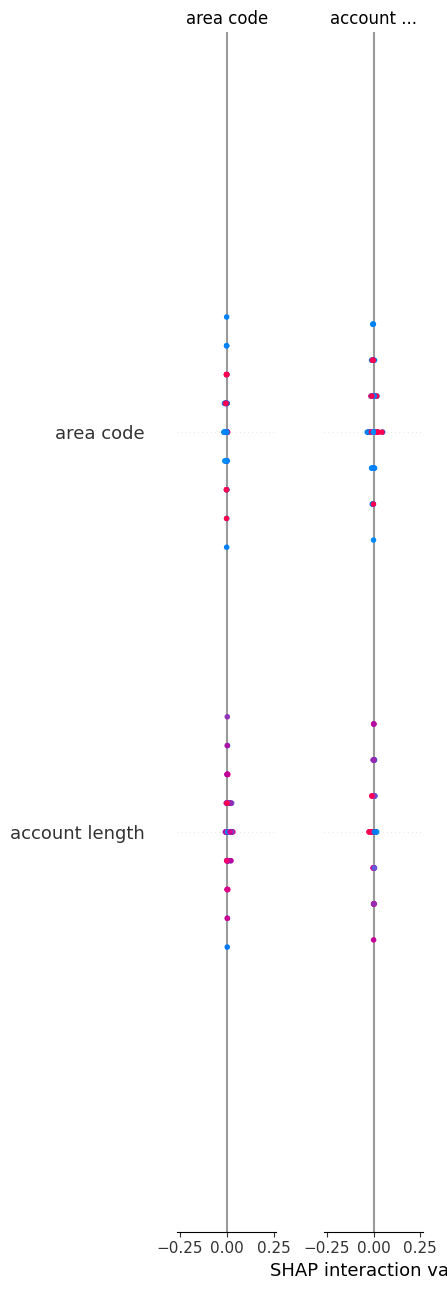

✅ Saved Beeswarm plot: shap_plots/RF_SMOTE_global_beeswarm.png


<Figure size 1000x600 with 0 Axes>

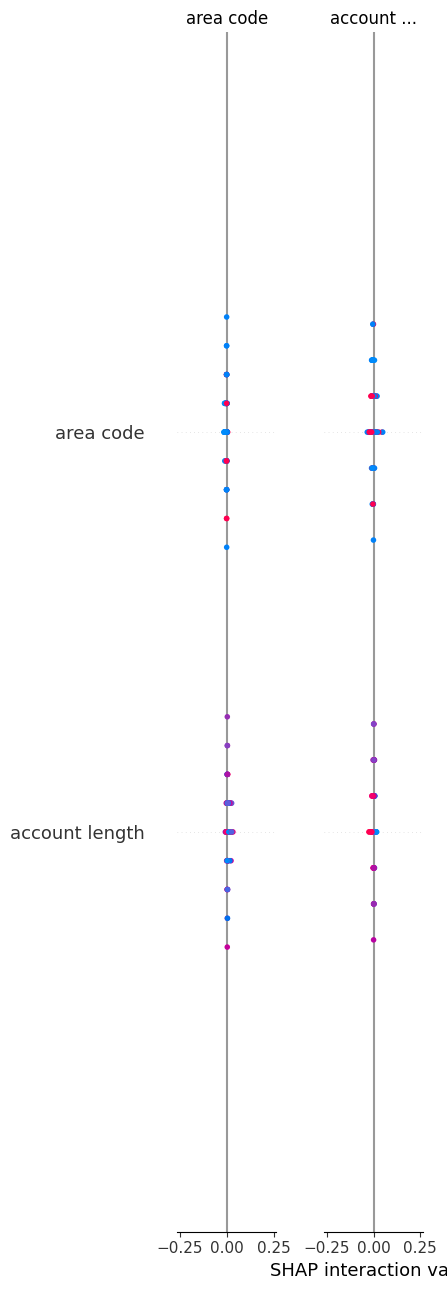

✅ Saved Bar plot: shap_plots/RF_SMOTE_global_bar.png
Local SHAP - Instance 0


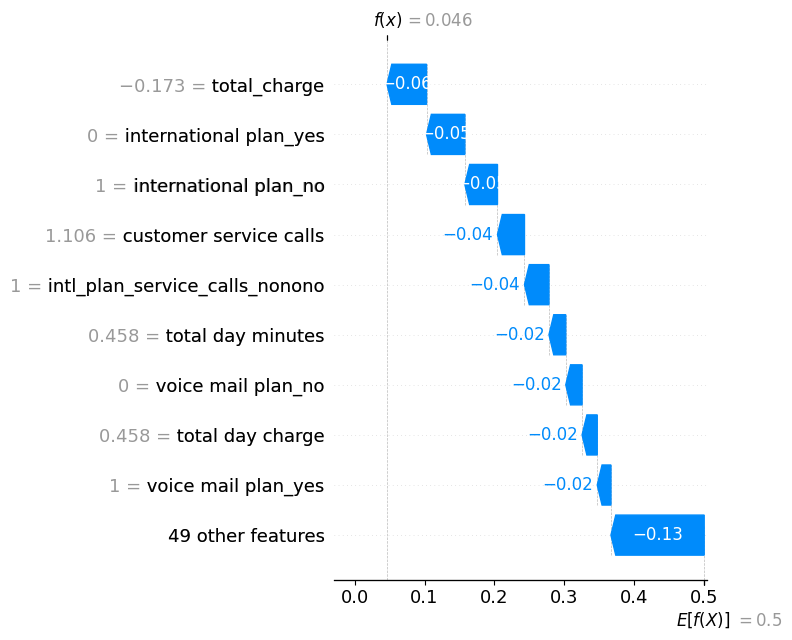

✅ Saved Waterfall plot: shap_plots/RF_SMOTE_local_waterfall_0.png


Force Plot (interactive):


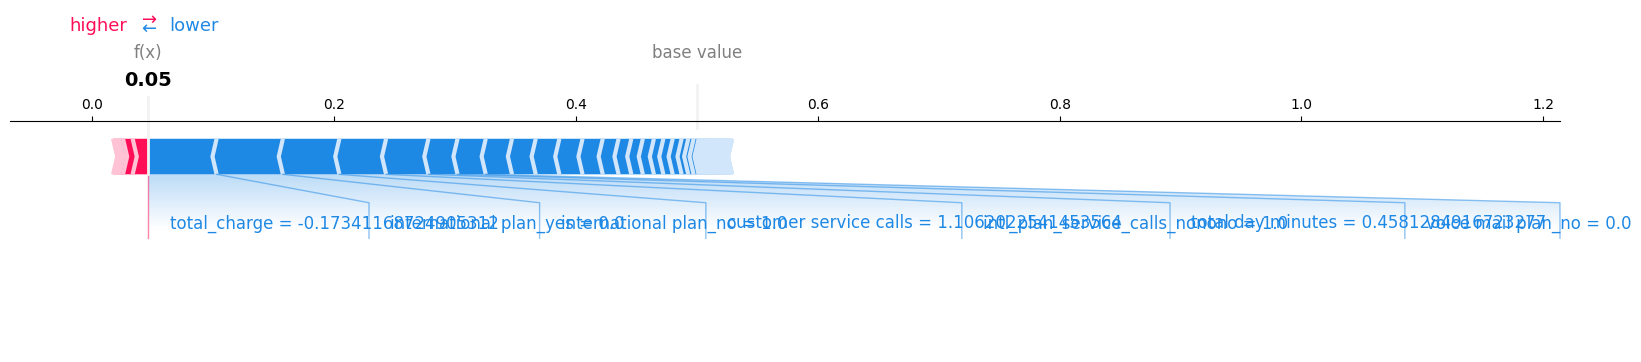

None


===== SHAP Explanation for GB_SMOTE =====
Global SHAP - Beeswarm & Bar Plots


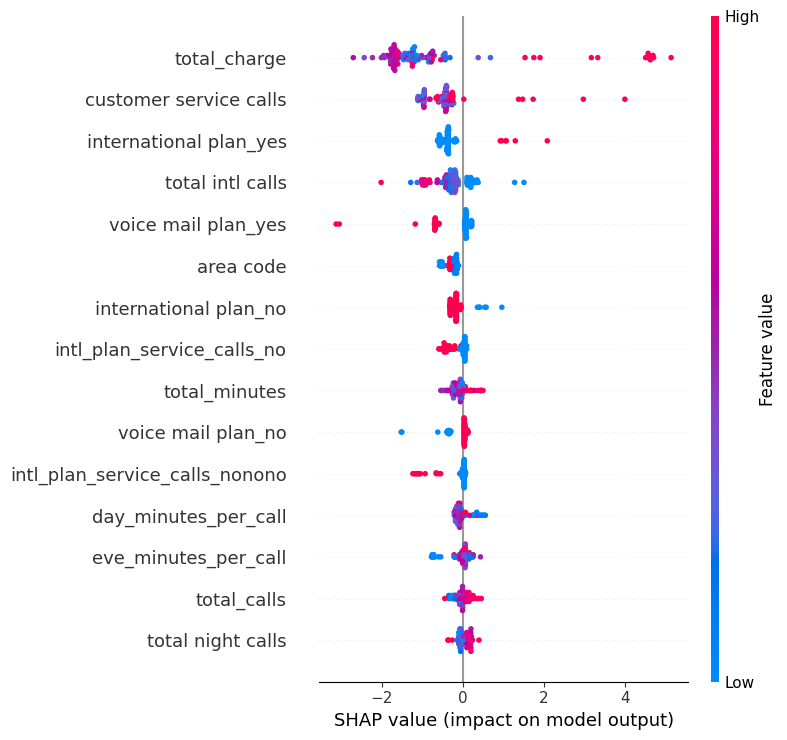

✅ Saved Beeswarm plot: shap_plots/GB_SMOTE_global_beeswarm.png


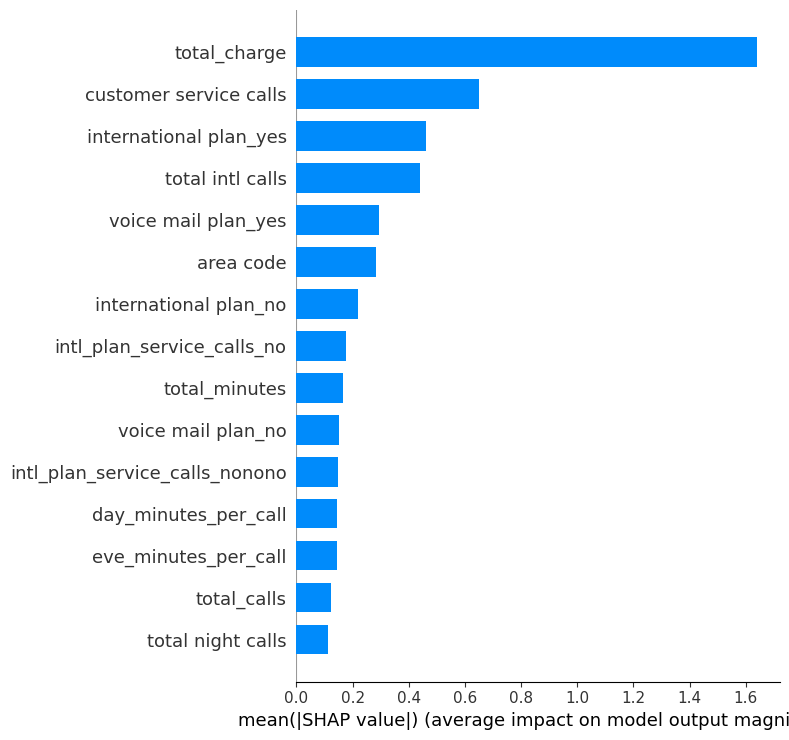

✅ Saved Bar plot: shap_plots/GB_SMOTE_global_bar.png
Local SHAP - Instance 0


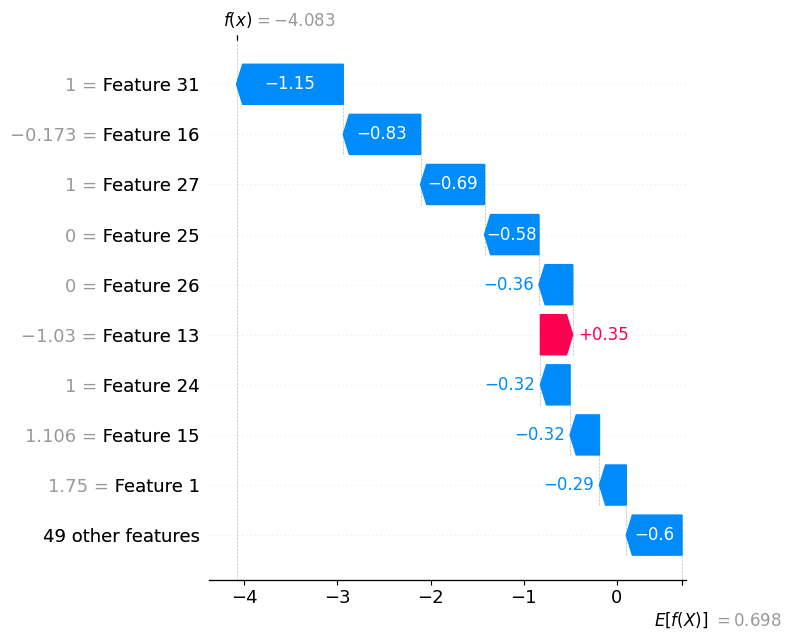

✅ Saved Waterfall plot: shap_plots/GB_SMOTE_local_waterfall_0.png


Force Plot (interactive):


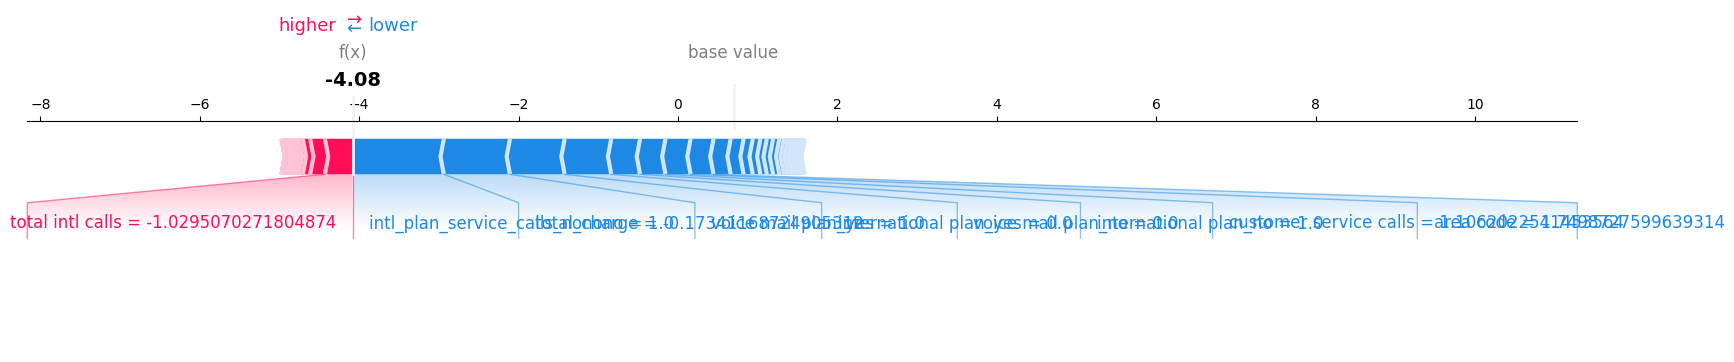

None


===== SHAP Explanation for LR_SMOTE =====
Global SHAP - Beeswarm & Bar Plots


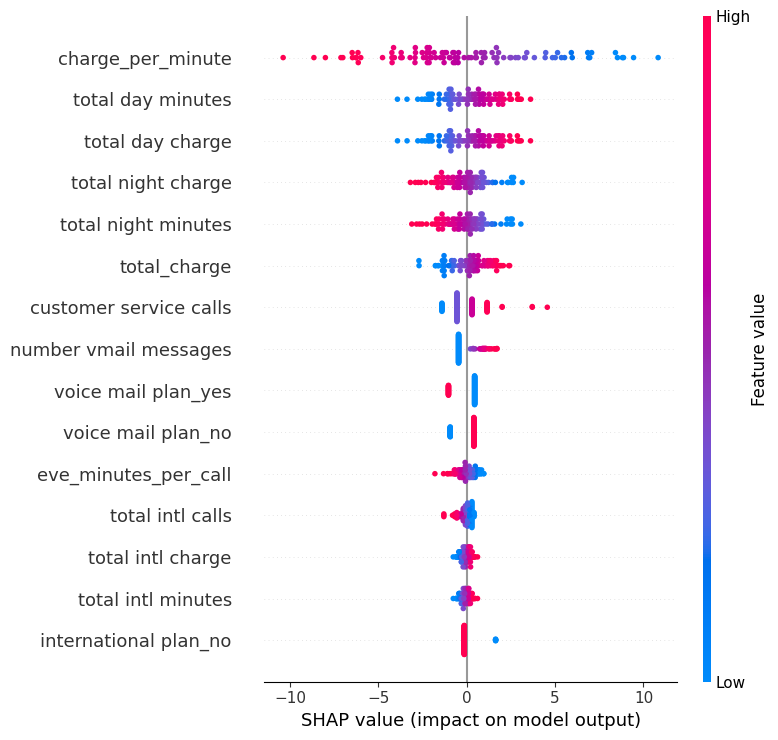

✅ Saved Beeswarm plot: shap_plots/LR_SMOTE_global_beeswarm.png


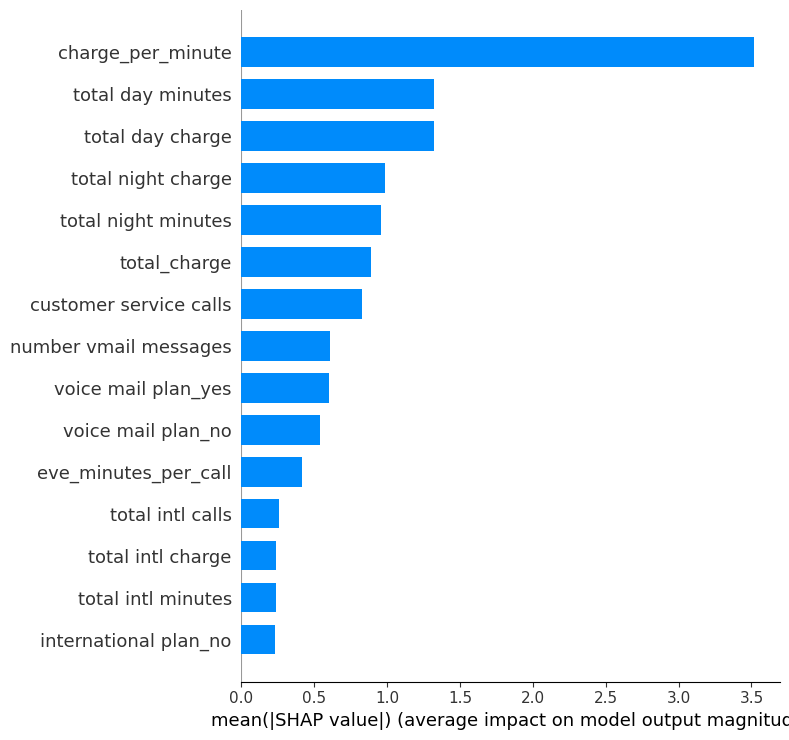

✅ Saved Bar plot: shap_plots/LR_SMOTE_global_bar.png
Local SHAP - Instance 0


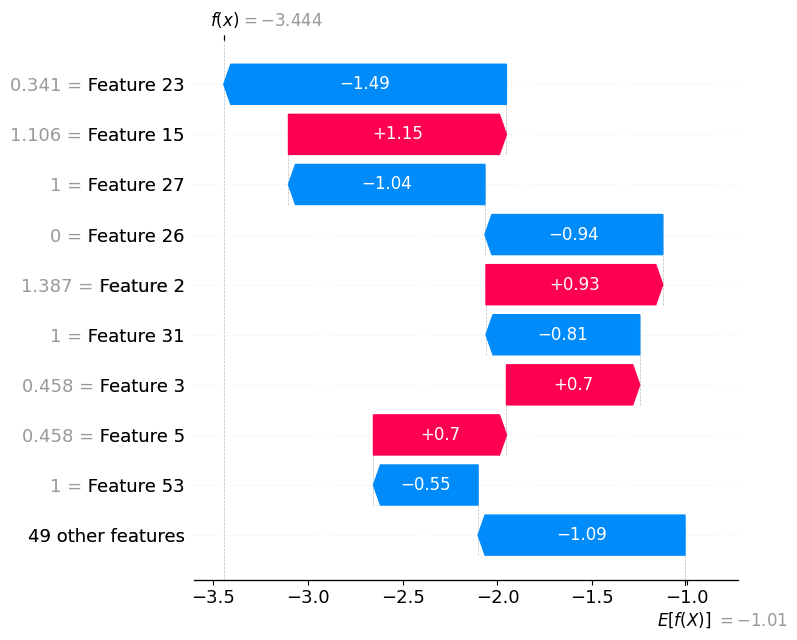

✅ Saved Waterfall plot: shap_plots/LR_SMOTE_local_waterfall_0.png


Force Plot (interactive):


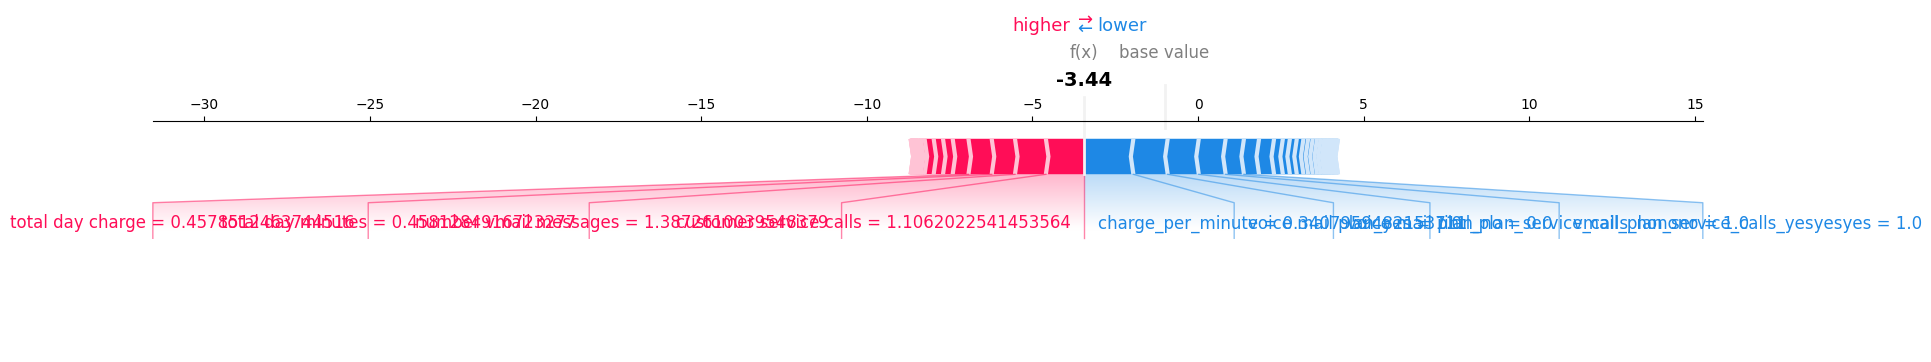

None

In [ ]:
# ==============================
# ✅ SHAP EXPLAINABILITY BLOCK (Fixed)
# ==============================
import shap
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def explain_with_shap(
    pipeline,
    model_name,
    X_train,
    X_test,
    num_samples=100,
    instance_idx=0,
    max_display_global=15,
    max_display_local=10,
    save_dir="shap_plots"
):
    """
    Generate SHAP explanations (global + local) for a fitted pipeline.
    """
    os.makedirs(save_dir, exist_ok=True)
    print(f"\n===== SHAP Explanation for {model_name} =====")

    # ---- Sample subset for speed ----
    X_sample = X_test.sample(min(num_samples, len(X_test)), random_state=42).reset_index(drop=True)
    if instance_idx >= len(X_sample):
        print(f"⚠️ instance_idx={instance_idx} exceeds sample size ({len(X_sample)}). Resetting to 0.")
        instance_idx = 0

    # ---- Extract model + preprocessor ----
    model = pipeline.named_steps['clf']
    preprocessor_step = pipeline.named_steps.get('preproc', None)
    if preprocessor_step is None:
        raise ValueError("❌ Preprocessor step not found in pipeline.")

    # ---- Transform data ----
    X_train_trans = preprocessor_step.transform(X_train)
    X_sample_trans = preprocessor_step.transform(X_sample)

    # ---- Get feature names after preprocessing ----
    feature_names = []
    for name, trans, cols in preprocessor_step.transformers_:
        if name == 'remainder':
            continue
        if hasattr(trans, 'get_feature_names_out'):
            feature_names.extend(trans.get_feature_names_out(cols))
        else:
            feature_names.extend(cols)

    # ---- Create SHAP explainer ----
    model_type = str(type(model))
    if "Forest" in model_type or "Boost" in model_type:
        explainer = shap.TreeExplainer(model)
    elif "LogisticRegression" in model_type:
        explainer = shap.LinearExplainer(model, X_train_trans, feature_perturbation="interventional")
    else:
        explainer = shap.Explainer(model, X_train_trans)

    # ---- Compute SHAP values ----
    shap_values = explainer(X_sample_trans)

    # ==============================
    # 🌍 GLOBAL SHAP PLOTS
    # ==============================
    print("Global SHAP - Beeswarm & Bar Plots")

    plt.figure(figsize=(6, 6))
    shap.summary_plot(
        shap_values, X_sample_trans,
        feature_names=feature_names,
        max_display=max_display_global,
        show=False
    )
    plt.tight_layout()
    beeswarm_path = os.path.join(save_dir, f"{model_name}_global_beeswarm.png")
    plt.savefig(beeswarm_path, dpi=300)
    plt.show()
    print(f"✅ Saved Beeswarm plot: {beeswarm_path}")

    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values, X_sample_trans,
        feature_names=feature_names,
        plot_type="bar",
        max_display=max_display_global,
        show=False
    )
    plt.tight_layout()
    bar_path = os.path.join(save_dir, f"{model_name}_global_bar.png")
    plt.savefig(bar_path, dpi=300)
    plt.show()
    print(f"✅ Saved Bar plot: {bar_path}")

    # ==============================
    # 👤 LOCAL SHAP PLOTS
    # ==============================
    print(f"Local SHAP - Instance {instance_idx}")
    shap_instance = shap_values[instance_idx]

    if hasattr(shap_instance, "values") and shap_instance.values.ndim == 2 and shap_instance.values.shape[1] == 2:
        shap_instance = shap.Explanation(
            values=shap_instance.values[:, 1],
            base_values=shap_instance.base_values[1] if np.ndim(shap_instance.base_values) > 0 else shap_instance.base_values,
            data=shap_instance.data,
            feature_names=feature_names
        )

    # Waterfall plot
    plt.figure(figsize=(10, 6))
    shap.plots.waterfall(shap_instance, max_display=max_display_local, show=False)
    plt.tight_layout()
    waterfall_path = os.path.join(save_dir, f"{model_name}_local_waterfall_{instance_idx}.png")
    plt.savefig(waterfall_path, dpi=300)
    plt.show()
    print(f"✅ Saved Waterfall plot: {waterfall_path}")

    # ✅ FIXED: Force plot using transformed features
    shap.initjs()
    print("Force Plot (interactive):")
    display(
        shap.force_plot(
            shap_instance.base_values,
            shap_instance.values,
            X_sample_trans[instance_idx, :],
            feature_names=feature_names,
            matplotlib=True
        )
    )

# ==============================
# 🚀 Example usage
# ==============================
explain_with_shap(pipelines["RF"], "RF_SMOTE", X_train, X_test)
explain_with_shap(pipelines["GB"], "GB_SMOTE", X_train, X_test)
explain_with_shap(pipelines["LR"], "LR_SMOTE", X_train, X_test)
